![image-2.png](attachment:image-2.png)
_Aprendizaje Automático_

_Máster Universitario en Inteligencia Artificial_

# Caso grupal: Detección de anomalías y técnicas de agrupamiento

## Objetivos

- Entender el método de clustering K-means.
- Generar agrupamientos con los métodos de clustering indicados y realizar una comparativa de ambos.
- Investigar sobre una técnica de detección de anomalías con un caso de uso concreto.


## Descripción de la actividad

El conjunto de datos con el cual vamos a trabajar se encuentra en el siguiente enlace http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

Se trata de un dataset que contiene mediciones del consumo de energía eléctrica en un hogar con una tasa de muestreo de un minuto durante un período de casi 4 años. Están disponibles diferentes magnitudes eléctricas y algunos valores de submedición. Debe descargarse el fichero comprimido que se encuentra en la carpeta 'Data Folder'.

### Tareas que se deben realizar
- Clustering
  - Debes completar el código pedido en este notebook y contestar las preguntas finales.
- Detección de anomalías
  - Buscar dos artículos científicos (https://scholar.google.es/) con un caso de uso de detección de anomalías. Los artículos deben estar en revistas científicas, y deben ser posteriores a 2015. No debe utilizar técnicas de Deep Learning.
  - Para cada artículo indicar:
    - Objetivo: cuál es el objetivo de la investigación, es decir a qué problema real está aplicando la detección de anomalías.
    - Técnicas de detección de anomalías empleadas.
    - Principales resultados de la aplicación y de la investigación.


### Clustering

Comenzamos importando las librerías necesarias y cargando el dataset.

In [36]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# se carga el dataset, con separados ;, se transforman las dos columnas Date y Time a una única columna con tipo datetime
# en el fichero CSV existen NaN identificados por ?
df = pd.read_csv('household_power_consumption.txt', sep=';',
                        parse_dates={'dt' : ['Date', 'Time']},
                        infer_datetime_format=True,low_memory=False,
                        na_values=['nan','?'])


C:\Users\ivoto\AppData\Local\Temp\ipykernel_22556\1946681039.py:9: FutureWarning:

Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.

C:\Users\ivoto\AppData\Local\Temp\ipykernel_22556\1946681039.py:9: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



C:\Users\ivoto\AppData\Local\Temp\ipykernel_22556\1946681039.py:9: UserWarning:

Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



2075259 instancias

In [37]:
print(df.shape)

(2075259, 8)


In [38]:
## cuál es el tipo de datos de la variable 'Voltage'.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   dt                     datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


- La variable Voltage es de tipo float64

In [40]:
## ¿es una variable continua o categórica?

- La variable "Voltage" es de tipo continuo.

In [41]:
# ¿cuáles son los valores mínimo y máximo de la variable 'Voltage'?

In [42]:
df['Voltage'].describe()

count    2.049280e+06
mean     2.408399e+02
std      3.239987e+00
min      2.232000e+02
25%      2.389900e+02
50%      2.410100e+02
75%      2.428900e+02
max      2.541500e+02
Name: Voltage, dtype: float64

- El mínimo valor de la variable Voltage es 223.2 (2.232000e+02)
- El máximo valor de la variable Voltage es 254.15 (2.541500e+02)

In [43]:
# ¿existe alguna variable con más del 30% de valores faltantes?

In [44]:
nan_count = df.isna().sum()
print(nan_count)
print("Porcentaje de datos perdidos:")
print(100 * nan_count.iloc[1] / df.shape[0])

dt                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Porcentaje de datos perdidos:
1.2518437457686005


- En base a los resultados obtenidos, podemos ver que un conjunto de 25979 filas tienen datos perdidos en cada una de las features (menos en dt)
- Calculado sobre el total de filas existentes, el pocentaje de datos perdidos por cada feature es de 1.251% lo que es menor al 30%, por lo que NO EXISTE ninguna variable con más del 30% de valores faltantes.es.

In [45]:
# ¿cuántas variables categóricas hay en el dataset?

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   dt                     datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


Indica las categorías de cada una de ellas si las hubiera.

- Evaluando el tipo de datos de las features (float64) a excepción de dt (que se compone de fecha y hora) no se observa ninguna variable categórica.
- Finalmente, podemos decir que la única variable que podríamos considerar "categórica" en este caso es, como cita la documentación, la hora, que se combina en fecha y hara en el dataset. Pero no sería categórica a nivel práctico en este caso.

Para los algoritmos de clustering el dataset no puede tener instancias con datos faltantes. ¿Tiene este dataset datos faltantes?

In [47]:
nan_count = df.isna().sum()
print(nan_count)

dt                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


- Como hemos comentado anteriormente, existen 25979 filas en las que todas las features tienen datos faltantes.

Existen diferentes alternativas para completar los datos faltantes, algunas de ellas las hemos estudiado en la asignatura.
Sin embargo, en esta actividad vamos a prescindir de estos datos.

In [48]:
df.dropna(inplace=True)

In [49]:
# Calcula las correlaciones de Pearson de las variables

In [50]:
correlations = df.corr()
correlations

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,1.000000,-0.041838,0.053472,0.249370,-0.045805,-0.014364,-0.037956,0.054291
Global_active_power,-0.041838,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.053472,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,0.249370,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,-0.045805,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,-0.014364,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,-0.037956,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.054291,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


¿Cuál es la variable que tiene mayor correlación con 'Global_active_power'? ¿Son variables dependientes o independientes?

In [51]:
sorted_correlations = (correlations['Global_active_power']).drop('Global_active_power').sort_values(ascending=False)
print(sorted_correlations)

Global_intensity         0.998889
Sub_metering_3           0.638555
Sub_metering_1           0.484401
Sub_metering_2           0.434569
Global_reactive_power    0.247017
dt                      -0.041838
Voltage                 -0.399762
Name: Global_active_power, dtype: float64


- La mayor correlación de Global_active_power se da con la feature Global_intensity

¿Podemos eliminar alguna variable?

In [52]:
# eliminamos variable dt
dataFrame = df.drop(columns='dt')
dataFrame

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,0.934,0.000,239.70,3.8,0.0,0.0,0.0


¿Es necesario hacer algún tratamiendo adicional sobre los datos?

- Cuando las características de los datos tienen diferentes escalas, el algoritmo K-means puede verse sesgado hacia las características con varianzas más altas. Esto puede llevar a una asignación desproporcionada de centroides y a resultados subóptimos. Normalizar los datos antes de aplicar K-means puede ayudar a mitigar este problema, asegurando que todas las características contribuyan de manera equitativa al cálculo de las distancias entre los puntos y los centroides. Por tanto, en nuesto caso sí será recomendable realizar la normalización de los datos (en nuestro caso usarémos standardScaler).

In [53]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(dataFrame)

Los métodos de clustering necesitan saber de antemano cuántos clusters deben crear.
¿Cuál es uno de los métodos más populares para saber cuál es el número apropiado de clústers?

- El método del codo = implica ejecutar el algoritmo de k-means varias veces con un número diferente de clústeres y calcular WCSS para cada uno. A medida que aumenta el número de clústeres, la WCSS tiende a disminuir, el punto donde se observa este cambio, donde la curva comienza a nivelarse, se considera una buena estimación para el número adecuado de clústeres.

Crea una lista de 20 modelos de KMeans y entrénalos.

Haciendo uso del método indicado en la respuesta anterior, indica cuál es el número de clusters que parece más prometedor.

El modelo de KMeans debe tener los siguientes parámetros:
- n_clusters (entre 1 y 20)
- init: k-means++
- algorithm: algoritmo de Lloyd

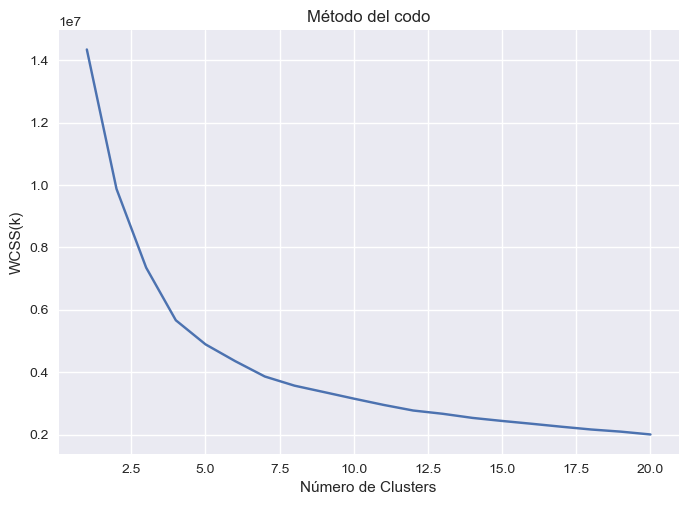

In [54]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 21):
     kmeans = KMeans(n_clusters = i, init = "k-means++", algorithm='lloyd', n_init=10 ,random_state = 0)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)
plt.plot(range(1,21), wcss)
plt.title("Método del codo")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS(k)")
plt.show()

A partir de estos resultados, ¿cómo sabemos cuál es el número óptimo de clústers? ¿qué número es?

- Observando el por el método del codo, podemos ver claramente que entre 3 y 5 Clusters esta el el cambio de dirrección, por lo que obtamos por un k = 4

In [55]:
# Después de decidir el número de clusters, entrena el modelo con dicho número
n = 4

In [56]:
kmeans = KMeans(n_clusters = n).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

c:\Users\ivoto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[[-0.61073308 -0.11206395  0.28571562 -0.60315071 -0.17559338 -0.15358924
  -0.71073153]
 [ 0.70712993  0.10381676 -0.35603322  0.68933493 -0.14822517 -0.13891685
   1.19781049]
 [ 2.74251988  0.68480693 -1.1325614   2.76840456  5.7811015   0.1637565
   0.56680421]
 [ 2.47963408  0.62009395 -0.96891355  2.50997468 -0.01074915  5.84981007
   0.49900736]]


In [57]:
kmeansmodel = KMeans(n_clusters = n, init='k-means++', random_state=0)
y_kmeans = kmeansmodel.fit_predict(X)

c:\Users\ivoto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Ahora toca interpretar lo que Kmeans ha realizado. Recordemos que el objetivo de KMeans es encontrar patrones en los datos.

Lo primero que vamos a realizar es un gráfico para visualizar los clústers que ha creado en base a las variables utilizadas para crearlos.

In [58]:
import plotly.express as px
import pandas as pd

columns_names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
clusters = pd.DataFrame(X, columns=columns_names)
clusters['label'] = kmeansmodel.labels_
polar = clusters.groupby("label").mean().reset_index()
polar = pd.melt(polar, id_vars=["label"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True, height=800, width=600)
fig4.show()

c:\Users\ivoto\anaconda3\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



En base a la figura de la representación de los clusters, ¿cuál es la variable que más nos ayuda a diferenciar los usos?

- A simple vista, parece que la variable Sub_metering_1 muestra una considerable variación entre los diferentes clusters. Podría ser una variable clave para diferenciar entre al menos uno de los clusters y los demás

In [59]:
pie = clusters.groupby('label').size().reset_index()
pie.columns = ['label','value']
px.pie(pie,values ='value',names ='label')

¿Qué representa el gráfico de la celda anterior?

- Es la distribución de los clusters obtenidos en tu análisis en funcion de las variables, es decir, el número de puntos que contiene ese cluster.

¿Qué características tiene el consumo del cluster 0?

- El cluster 0, según el gráfico de pastel es el más grande y contiene la mayor cantidad de puntos, es decir que las carracteristicas de este cluster son las que más comunes dentro del conjunto de datos.
- Por otra parte en el gráfico de radar, el cluster 0 muestra valores similares en todas las variables, esto sugiere que los puntos en este cluster no están definidos por extremos en ninguna de las características medidas.

Repite lo mismo pero esta vez utiliza para el entrenamiento de KMeans el algortimo de 'Elkan', ¿existen diferencias en el número de clústers? ¿y en la importancia de las variables?

c:\Users\ivoto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.



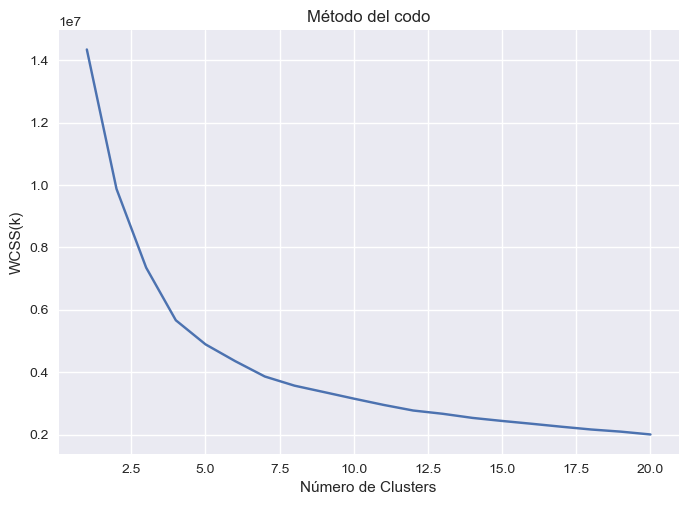

In [60]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 21):
     kmeans = KMeans(n_clusters = i, init = "k-means++", algorithm='elkan', n_init=10 ,random_state = 0)
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)
plt.plot(range(1,21), wcss)
plt.title("Método del codo")
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS(k)")
plt.show()

- Podemos observar que el codo se manifiesta al redodor de k = 4 por lo que no notamos diferencia con el algoritmo anterior.


In [61]:
kmeans = KMeans(n_clusters = n).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

kmeansmodel = KMeans(n_clusters = n, init='k-means++', random_state=0)
y_kmeans = kmeansmodel.fit_predict(X)

c:\Users\ivoto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



[[ 2.4796764   0.6201039  -0.96893183  2.51001793 -0.01074556  5.84985809
   0.49903383]
 [ 0.70716639  0.1037455  -0.35605196  0.68936849 -0.14823214 -0.13891922
   1.19792856]
 [-0.61069137 -0.11201409  0.28569596 -0.60310857 -0.17558824 -0.15358427
  -0.71070871]
 [ 2.74251988  0.68480693 -1.1325614   2.76840456  5.7811015   0.1637565
   0.56680421]]


c:\Users\ivoto\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [62]:
columns_names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1', 'Sub_metering_2','Sub_metering_3']
clusters = pd.DataFrame(X, columns=columns_names)
clusters['label'] = kmeansmodel.labels_
polar = clusters.groupby("label").mean().reset_index()
polar = pd.melt(polar, id_vars=["label"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True, height=800, width=600)
fig4.show()

c:\Users\ivoto\anaconda3\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [63]:
pie = clusters.groupby('label').size().reset_index()
pie.columns = ['label','value']
px.pie(pie,values ='value',names ='label')

- Concluimos que los graficos tipo radar y torta dan los mismo resultados y esto es totalmente factible, ya que los algoritmos buscan minimizar la suma de las distancias cuadradas de los puntos de datos a sus centros de cluster más cercanos y la principal diferencia entre ellos es su eficiencia computaciona.

### Detección de anomalías

Artículo 1

_introduce aquí la referencia APA del artículo_

título, autores, revista, año de publicación

Objetivo: cuál es el objetivo de la investigación, es decir a qué problema real está aplicando la detección de anomalías.
Técnicas de detección de anomalías empleadas.
Principales resultados de la aplicación y de la investigación.

- Objetivo: El objetivo es aplicar la detección de anomalías para monitorear las condiciones de los motores utilizando datos de series temporales de sensores. El problema real es detectar anomalías en el funcionamiento del motor para prevenir fallos y optimizar el mantenimiento.
- Técnicas de detección de anomalías empleadas: Este artículo utiliza técnicas clásicas de detección de anomalías en series temporales, como métodos estadísticos y de modelado probabilístico.
- Principales resultados: Los autores proponen un enfoque que muestra una buena capacidad para detectar anomalías en los datos del sensor del motor, lo que permite una mejor gestión del mantenimiento y la prevención de fallos.
- Referencia APA: Jiang, X., Zheng, W., Jiang, Y., & Gao, L. (2017). Anomaly Detection in Time Series Sensor Data for Engine Condition Monitoring. IEEE Transactions on Instrumentation and Measurement.
- Enlace: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=Anomaly+Detection+in+Time+Series+Sensor+Data+for+Engine++++Condition+Monitoring.&btnG=

Artículo 2

_introduce aquí la referencia APA del artículo_

título, autores, revista, año de publicación

Objetivo: cuál es el objetivo de la investigación, es decir a qué problema real está aplicando la detección de anomalías.
Técnicas de detección de anomalías empleadas.
Principales resultados de la aplicación y de la investigación.

- Objetivo: El objetivo es comparar diferentes técnicas de detección de anomalías para mejorar la seguridad de las redes (redes entendidas como Internet, no neuronales). El problema real es identificar comportamientos anómalos en la red que puedan indicar intrusiones o actividades maliciosas.
- Técnicas de detección de anomalías empleadas: Este artículo examina varias técnicas clásicas de detección de anomalías en redes, como métodos basados en estadísticas, clustering y aprendizaje no supervisado.
- Principales resultados: Los autores proporcionan una comparación exhaustiva de las técnicas de detección de anomalías en redes y ofrecen recomendaciones sobre cuáles son más efectivas en diferentes escenarios de seguridad.
- Referencia APA: Chandola, V., Banerjee, A., & Kumar, V. (2009). A Comparative Study of Anomaly Detection Techniques in Network Security. Proceedings of the 2009 SIAM International Conference on Data Mining.
- Enlace: https://www.researchgate.net/publication/220907138_A_Comparative_Study_of_Anomaly_Detection_Schemes_in_Network_Intrusion_Detection